<a href="https://colab.research.google.com/github/alijaalejandro/Medical-Image-Clasification/blob/main/source/CNN-Clasificador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
knitr::opts_chunk$set(echo = TRUE, 
                      cache = TRUE, 
                      message = FALSE, 
                      warning = FALSE, 
                      dpi = 600)


# Introducción

En este ejemplo, mostramos la capacidad de los algoritmos de Deep Learning para clasificar imágenes de radiodiagnóstico médico. El objetivo de este proyecto es entrenar a un algoritmo para que sea capaz de clasificar automáticamente una imágen de una radiografía de pecho en dos categorías (enferma vs no-enferma).

# Proyectos previos

Este proyecto es una adaptación del proyecto original de Michael Blum [tweeted](https://twitter.com/mblum_g/status/1475940763716444161?s=20) sobre el desafío [STOIC2021 - dissease-19 AI challenge](https://stoic2021.grand-challenge.org/stoic2021/). El proyecto roiginal de Michael partía de un conjunto de imágenes de pacientes con patología dissease-19 junto con otros pacientes sanos para hacer de contraste. Del proyecto original de Michael, [Olivier Gimenez](https://oliviergimenez.github.io/) utilizó un conjunto de datos similar al del proyetco original publicado en una competición de [Kaggle](https://en.wikipedia.org/wiki/Kaggle) repository <https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset>. La razón de utilizar este nuevo dataset es que era considerablemente más manejable que el original (280GB). El nuevo dataset pesaba alrededor de 250MB y contenía algo más de 1000 imágenes de pacientes sanos y enfermos. El código del proyecto de Olivier puede encontrase en [Github](https://github.com/oliviergimenez/bin-image-classif).

# Conjunto de Datos

En nuestro caso, inspirándonos en estos dos fantásticos proyectos previos, damos un paso más. En este proyecto, partimos de un conjunto de datos (imágenes médicas) de radio-diagnóstico que están disponibles en el repositorio abierto del [NIH](https://clinicalcenter.nih.gov/). El Centro Clínico NIH es un hospital dedicado únicamente a la investigación clínica en el campus de los Institutos Nacionales de Salud en Bethesda, Maryland (EEUU). En el post [10 repositorios de datos públicos relacionados con la salud y el bienestar](https://datos.gob.es/es/noticia/10-repositorios-de-datos-publicos-relacionados-con-la-salud-y-el-bienestar) se cita al NIH como uno de los orígenes de datos sanitarios de calidad.

En particular, nuestro conjunto de datos está disponible públicamente [aquí](https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345). El repositorio incluye toda la información necesario para usarlo y en la descripción los autores comentan:

> El examen de rayos X de tórax es uno de los exámenes de imágenes médicas más frecuentes y rentables. Sin embargo, el diagnóstico clínico de la radiografía de tórax puede ser un desafío y, a veces, se cree que es más difícil que el diagnóstico mediante imágenes de [TC](https://es.wikipedia.org/wiki/Tomograf%C3%ADa_axial_computarizada) (Tomografía Computerizada) de tórax\_

El conjunto de datos de rayos X de tórax comprende **112.120** imágenes de rayos X de vista frontal de **30.805** pacientes únicos con las **etiquetas de imágenes de catorce enfermedades** extraídas de texto (donde cada imagen puede tener múltiples etiquetas), extraídas de los informes radiológicos asociados utilizando procesamiento de lenguaje natural.

Ejemplo de imágen del repositorio: ![imagen de paciente sano](https://github.com/alijaalejandro/Medical-Image-Clasification/blob/main/images/00012908_000.jpg?raw=1)

# El código paso a paso

##Instalación de dependencias


In [50]:
install <- T
if (install==T){
install.packages("keras")
install.packages("httr")
install.packages("tidyverse")
install.packages("rmarkdown")
install.packages("reshape2")
install.packages("patchwork")

}


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Carga de dependencias

Lo primero que debemos hacer es cargar las dependencias (librerías) que vamos a necesitar en nuestro análisis. El paquete de R más representativo de este conjunto de dependencias es [Keras](https://keras.io/). En este [post]() ya comentamos sobre el uso de Keras como framework de Deep Learning.


In [51]:
library(tidyverse)
library(httr)
library(rmarkdown)
theme_set(theme_light())
library(keras)
library(reshape2)
library(patchwork)


## Acceso a datos

Para ejecutar este Notebook en (Google Colab)[https://colab.research.google.com/]
debemos de importar los datos al espacio local de trabajo de Colab. Los pasos son los siguientes:

1. Accedemos a la [siguiente dirección](https://drive.google.com/drive/folders/1jZkgiSgT7ab_wQynxtkY4QpIxljbsWvi?usp=sharing) en Google Drive y descargamos el directorio comprimido de los datos.

2. Descomprimimos el directorio en nuestro ordenador local.

3. Creamos unos directorios en Google Colab para guardar los datos de las imágenes.


In [52]:
#Creamos directorios locales
system("mkdir data")
system("mkdir data/Pneumothorax")
system("mkdir data/No-Finding")


4. Subimos manualmente los ficheros de imágen de acuerdo a la organización de cada carperta a Google Colab. Para ello, hacemos clic con botón derecho sobre cada una de los nuevos directorios en Colab y subimos las imágenes correspondientes.

Una vez subidos los ficheros debemos de ver algo tal que así en Google Colab.

Ejemplo de imágenes de datos: ![imágenes en Colab](https://github.com/alijaalejandro/Medical-Image-Clasification/blob/main/images/resultado_colab.jpeg?raw=1)



# Lectura de datos

Utilizando esta función leemos y preprocesamos todas las imágenes con las que vamos a querer trabajar. Esta función procede del [post original](https://rpubs.com/spalladino14/653239) escrita por [Spencer Palladino](https://www.linkedin.com/in/spencer-palladino/).


In [53]:
process_pix <- function(lsf) {
  img <- lapply(lsf, image_load, color_mode = "grayscale") # grayscale the image
  arr <- lapply(img, image_to_array) # turns it into an array
  arr_resized <- lapply(arr, image_array_resize, 
                        height = 100, 
                        width = 100) # resize
  arr_normalized <- normalize(arr_resized, axis = 1) #normalize to make small numbers 
  return(arr_normalized)
}


En este fragmento de código cargamos las imágenes desde de los directorios donde las hemos dejado previamente.



In [54]:
lsf <- list.files("./data/Pneumothorax", full.names = TRUE) 

# Restrinjo la lista a 1000 elementos. 
lsf2 <- lsf[1:length(lsf)]

dissease <- process_pix(lsf2)

dissease <- dissease[,,,1]
dissease_reshaped <- array_reshape(dissease, c(nrow(dissease), 100*100))

# Imágenes de personas SIN patologías
lsf3 <- list.files("./data/No-Finding", full.names = TRUE) 

# Restrinjo la lista a 1000 elementos. 
lsf4 <- lsf3[1:length(lsf3)]

ndissease <- process_pix(lsf4)
ndissease  <- ndissease[,,,1]
ndissease_reshaped <- array_reshape(ndissease, c(nrow(ndissease), 100*100))


Tenemos `r nrow(dissease_reshaped)` imágenes de rayos-x de personas con enfermedad y `r nrow(dissease_reshaped)` imágenes de personas sin enfermedad.

# Visualización previa de los datos/imágenes


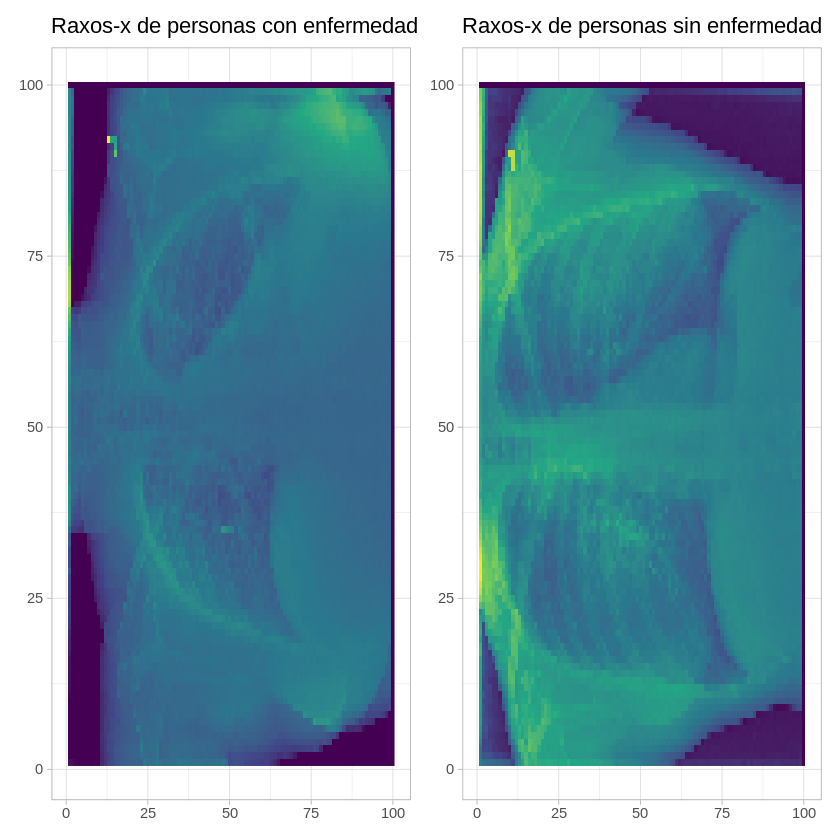

In [55]:
scandissease <- reshape2::melt(dissease[10,,])
plotdissease <- scandissease %>%
  ggplot() +
  aes(x = Var1, y = Var2, fill = value) + 
  geom_raster() +
  labs(x = NULL, y = NULL, title = "Raxos-x de personas con enfermedad") + 
  scale_fill_viridis_c() + 
  theme(legend.position = "none")

scanndissease <- reshape2::melt(ndissease[10,,])
plotndissease <- scanndissease %>%
  ggplot() +
  aes(x = Var1, y = Var2, fill = value) + 
  geom_raster() +
  labs(x = NULL, y = NULL, title = "Raxos-x de personas sin enfermedad") + 
  scale_fill_viridis_c() + 
  theme(legend.position = "none")

library(patchwork)
plotdissease + plotndissease


# Comenzamos el análisis

Lo primero que vamos a hacer es mezclar las imágenes de pacientes con enfermedad y sin ella.


In [56]:
df <- rbind(cbind(dissease_reshaped, 1), # 1 = dissease
            cbind(ndissease_reshaped, 0)) # 0 = no dissease
set.seed(1234)
shuffle <- sample(nrow(df), replace = F)
df <- df[shuffle, ]


# El modelo: Convolutional neural network (CNN)

Lo primero que hacemos dividir el conunto total de imágenes en dos conjuntos siguiendo la proporción (80%/20%). Es decir, vamos a entrenar el algoritmo con el 80% de las imágenes y validarlo con el 20% restante.


In [57]:
set.seed(2022)
split <- sample(2, nrow(df), replace = T, prob = c(0.8, 0.2))
train <- df[split == 1,]
test <- df[split == 2,]
train_target <- df[split == 1, 10001] # label in training dataset
test_target <- df[split == 2, 10001] # label in testing dataset


Ahora construimos nuestro modelo. Utilizamos una red neuronal de tres capas (función `layer_dense()`).



In [58]:
model <- keras_model_sequential() %>%
  layer_dense(units = 512, activation = "relu") %>% 
  layer_dropout(0.4) %>%
  layer_dense(units = 256, activation = "relu") %>%
  layer_dropout(0.3) %>%
  layer_dense(units = 128, activation = "relu") %>%
  layer_dropout(0.2) %>%
  layer_dense(units = 2, activation = 'softmax')


Compilamos el modelo con la optimizacion para una clasificación binaria. Es decir, aquí clasificamos si el paciente tiene enfermedad o no la tiene.



In [59]:
model %>%
  compile(optimizer = 'adam',
          loss = 'binary_crossentropy', 
          metrics = c('accuracy'))


Convertimos las etiquetas de enfermedad/no-enfermedad a un tipo de datos de tipo factor o categórico.



In [60]:
train_label <- to_categorical(train_target)
test_label <- to_categorical(test_target)


Una vez entrenado el modelo, vamos a intentar hacer un ajuste sobre el 20% de los datos que dejamos para test.



In [61]:
fit_dissease <- model %>%
  fit(x = train,
      y = train_label, 
      epochs = 25,
      batch_size = 512, # try also 256, 512
      verbose = 2,
      validation_split = 0.2)


Una visualización rápida sobre como se comporta el algoritmo sobre las imágenes que hemos reservado para validar.



`geom_smooth()` using formula 'y ~ x'



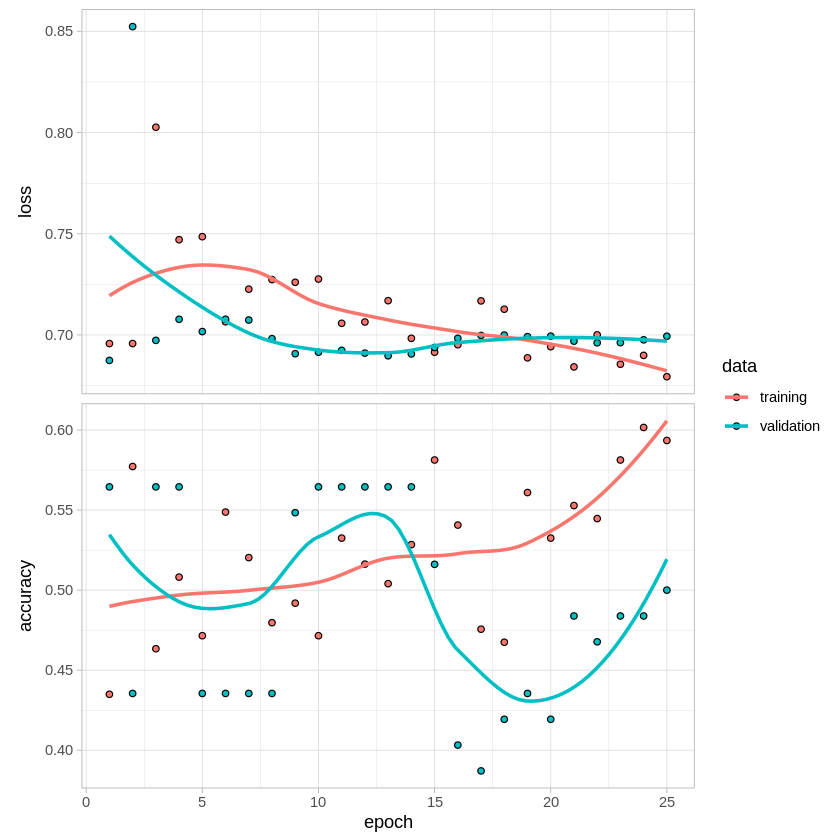

In [62]:
plot(fit_dissease)



Calculamos las métricas de rendimiento del algoritmo.



In [63]:
model %>%
  evaluate(test, test_label)


loss  accuracy 
0.6991995 0.4883721

Hacemos ahora algunas predicciones sobre imágenes de pacientes. Es decir, una vez entrenado y validado el algoritmo, nos preguntamos como va a clasiificar las imágenes que le vamos a dar ahora. Como sabemos "la verdad" (lo que se denomina el ground truth) sobre las imágenes, comparamos el resultado de la predicción con la verdad (lo que se denomina una tabla de confusión)



In [64]:
predictedclasses <- model %>%
  predict(test) %>% `>`(0.5) %>% k_cast("int32")
table(Prediction = as.numeric(predictedclasses[,2]), Truth = test_target)


          Truth
Prediction  0  1
         0 28 21
         1 23 14

Muy genial. XXX se clasifica erróneamente como enfermo. Guardemos nuestro modelo para un uso posterior.



In [65]:
save_model_tf(model, "model/disseasemodel") # save the model



# Conclusiones

Hemos entrenado una algoritmo de tipo CNN Convolutional neural network-CNN para realizar clasificaciones binarias (enfermo vs no-enfermo) sobre un conjunto de imágenes de rayos-x de pecho tanto de pacientes sanos como de pacientes con varias patologías. Por sencillez, hemos escogido pacientes sanos y pacientes que presentan un Pneumothorax previamente identificado por un médico. El resultado del entrenamiento nos ofrece un algoritmo
